Коваленко Лиана User ID: 265683406

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/).


# Vanilla Autoencoder (2 балла)

## Prepare the data
Импортируем необходимые библиотеки


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import os
from skimage.transform import resize
import skimage.io
import pandas as pd

Загрузим данные

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
data, attrs = fetch_dataset()


Разбьем выборку картинок на train и val, приведем картинки к тензорам pytorch, чтобы можно было скормить их сети

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
train_X, val_X, train_Y, val_Y  = train_test_split(data, attrs.to_numpy(dtype=float), test_size=0.25)
torch.from_numpy(train_X).type(torch.FloatTensor)

train_X_torch = torch.from_numpy(train_X).type(torch.FloatTensor)
train_Y_torch = torch.from_numpy(train_Y).type(torch.FloatTensor)

val_X_torch = torch.from_numpy(val_X).type(torch.FloatTensor)
val_Y_torch = torch.from_numpy(val_Y).type(torch.FloatTensor)

train = TensorDataset(train_X_torch, train_Y_torch)
val = TensorDataset(val_X_torch, val_Y_torch)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=100,shuffle=False, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=100,shuffle=False, num_workers=4)

Выведем несколько картинок в output, чтобы посмотреть, как они выглядят

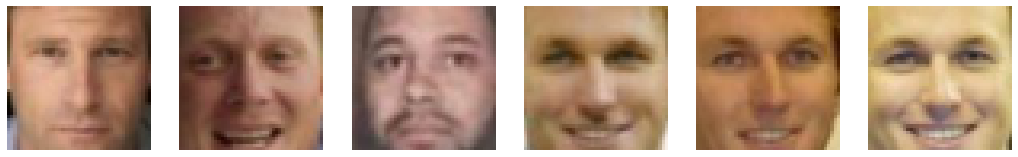

In [4]:
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])
plt.show();

Посмотрим, как выглядит таблица attrs

In [5]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Реализуем autoencoder

In [6]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      
      super(Autoencoder, self).__init__()

      self.encoder_1 = nn.Linear(
        in_features=45*45*3, out_features=45*45
      )
      self.encoder_2 = nn.Linear(
        in_features=45*45, out_features=1024
      )
      self.encoder_3 = nn.Linear(
        in_features=1024, out_features=512
      )
        
      self.decoder_3 = nn.Linear(
        in_features=512, out_features=1024
      )
      self.decoder_2 = nn.Linear(
        in_features=1024, out_features=45*45
      )
      self.decoder_1 = nn.Linear(
        in_features=45*45, out_features=45*45*3
      )

    def forward(self, features):
      
      code = self.encode(features)
      
      reconstruction = self.decode(code)

      return reconstruction, code

    def encode(self, x):
      x = torch.flatten(x, start_dim=1, end_dim=3)

      x = self.encoder_1(x)
      x = torch.relu(x)

      x = self.encoder_2(x)
      x = torch.relu(x)

      x = self.encoder_3(x)
      x = torch.relu(x)

      return x

    def decode(self, x):
      x = self.decoder_3(x)
      x = torch.relu(x)

      x = self.decoder_2(x)
      x = torch.relu(x)

      x = self.decoder_1(x)
      x = torch.sigmoid(x)

      return x

Выберем лосс и оптимизатор

In [7]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()

import torch.optim as optim
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

Напишем код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [8]:
losses = []

EPOCHS = 200

autoencoder.cuda()
autoencoder.train()
train_loss = 0

for epoch in range(EPOCHS):
    
  for batch_idx, (img, _) in enumerate(train_dataloader):
    img = img.cuda()
    optimizer.zero_grad()
    #print(data.shape)
    reconstruction, code = autoencoder(img)
    loss = criterion(reconstruction, img.view(-1, 6075))
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(img), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item() / len(img)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

Train Epoch: 0 [0/9857 (0%)]	Loss: 0.000448
====> Epoch: 0 Average loss: 0.0003
Train Epoch: 1 [0/9857 (0%)]	Loss: 0.000241
====> Epoch: 1 Average loss: 0.0005
Train Epoch: 2 [0/9857 (0%)]	Loss: 0.000199
====> Epoch: 2 Average loss: 0.0007
Train Epoch: 3 [0/9857 (0%)]	Loss: 0.000165
====> Epoch: 3 Average loss: 0.0008
Train Epoch: 4 [0/9857 (0%)]	Loss: 0.000134
====> Epoch: 4 Average loss: 0.0010
Train Epoch: 5 [0/9857 (0%)]	Loss: 0.000116
====> Epoch: 5 Average loss: 0.0011
Train Epoch: 6 [0/9857 (0%)]	Loss: 0.000110
====> Epoch: 6 Average loss: 0.0012
Train Epoch: 7 [0/9857 (0%)]	Loss: 0.000108
====> Epoch: 7 Average loss: 0.0013
Train Epoch: 8 [0/9857 (0%)]	Loss: 0.000107
====> Epoch: 8 Average loss: 0.0014
Train Epoch: 9 [0/9857 (0%)]	Loss: 0.000101
====> Epoch: 9 Average loss: 0.0015
Train Epoch: 10 [0/9857 (0%)]	Loss: 0.000095
====> Epoch: 10 Average loss: 0.0016
Train Epoch: 11 [0/9857 (0%)]	Loss: 0.000094
====> Epoch: 11 Average loss: 0.0017
Train Epoch: 12 [0/9857 (0%)]	Loss: 

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
plt.imshow(data[0])

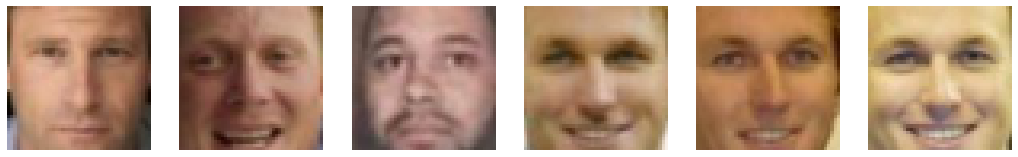

In [10]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])


plt.show();


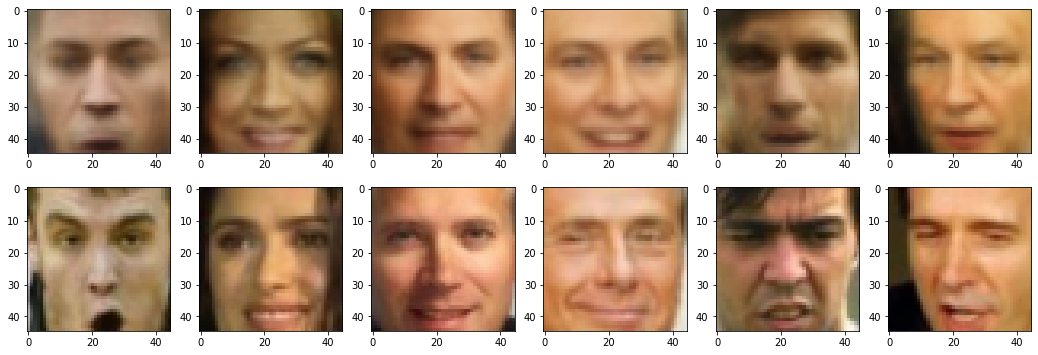

In [11]:
plt.figure(figsize=(18, 6))
for i, (val_data, _) in enumerate(val_dataloader):
    if i >= 6:
      break
    plt.subplot(2, 6, i + 1)
    result, kek = autoencoder(val_data.cuda())
    plt.imshow(result.cpu().detach().view(100, 45, 45, 3).numpy()[0])
    plt.subplot(2, 6, 5 + 1 + i + 1)
    plt.imshow(val_data.cpu()[0])

plt.show();

Not bad, right? 

## Sampling

Теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ.

Возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера

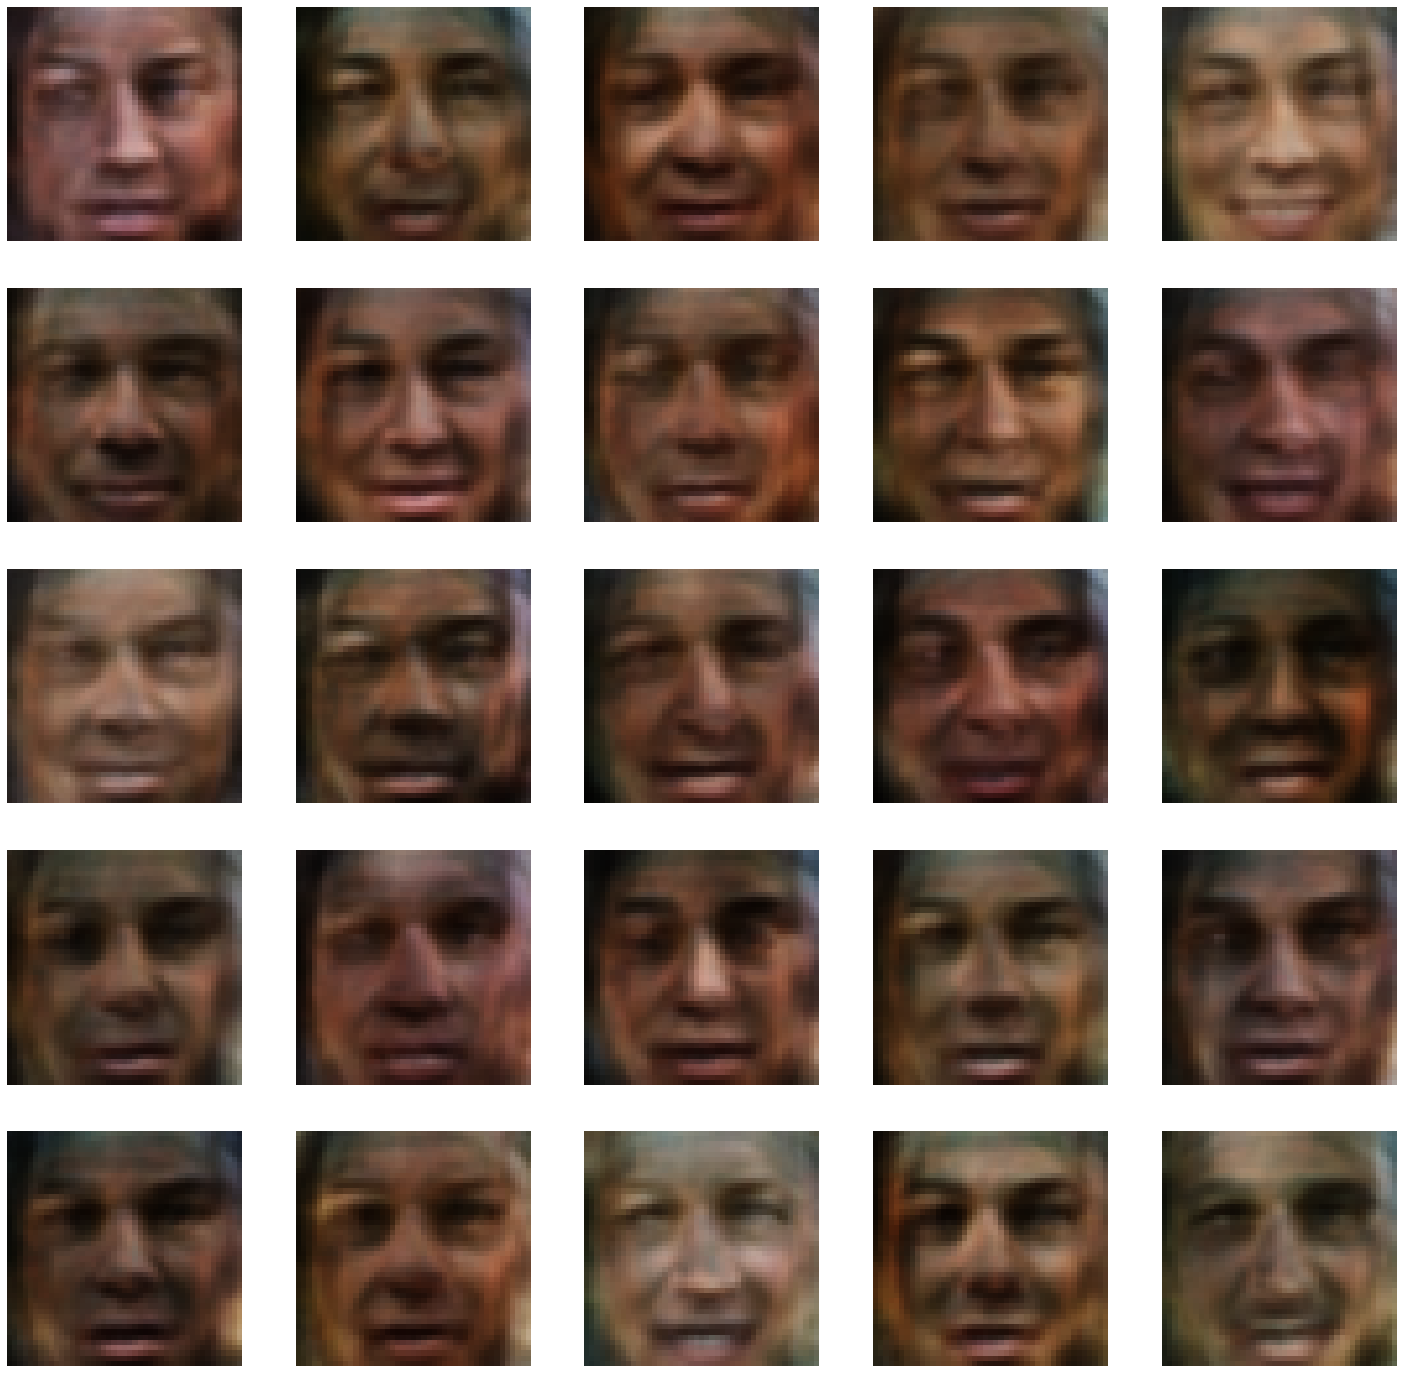

In [57]:
# сгенерируем 25 рандомных векторов размера latent_space

z = np.random.rand(25, 512)
z = torch.from_numpy(z).type(torch.FloatTensor)
z = z.cuda()

x = autoencoder.decode(z)

output = x

plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(output[i].cpu().detach().view(45, 45, 3).numpy())


plt.show();

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

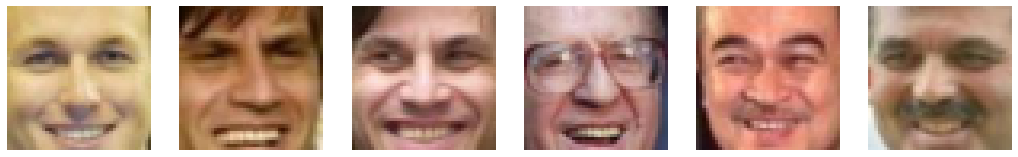

In [63]:
smile_idx = attrs[attrs['Smiling']>1]['Smiling'].index
smiling_ppl = torch.from_numpy(data[smile_idx[:25]]).type(torch.FloatTensor)

plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.axis("off")
  plt.imshow(smiling_ppl[i])


plt.show()
encoded_smile = autoencoder.encode(smiling_ppl.cuda())

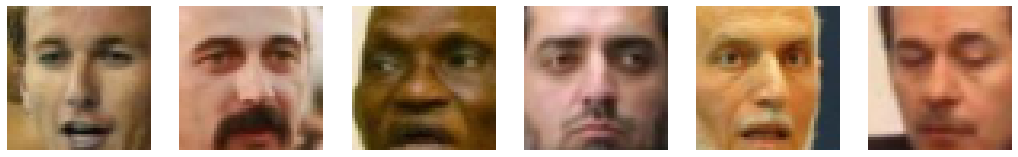

In [65]:
sad_idx = attrs[attrs['Smiling']<-1]['Smiling'].index
sad_ppl = torch.from_numpy(data[sad_idx[:25]]).type(torch.FloatTensor)

plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.axis("off")
  plt.imshow(sad_ppl[i])


plt.show();

encoded_sad = autoencoder.encode(sad_ppl.cuda())

In [66]:
mean_vector = torch.sub(torch.mean(encoded_smile, 0), torch.mean(encoded_sad, 0))
mean_vector.shape

torch.Size([512])

In [67]:
def make_sad_smile(sad_guy):
  sad_guy = torch.reshape(sad_guy, (1, 45, 45, 3))
  encoded_sad_guy = autoencoder.encode(sad_guy.cuda())
  now_happy_guy = autoencoder.decode(torch.add(encoded_sad_guy, mean_vector))
  return now_happy_guy

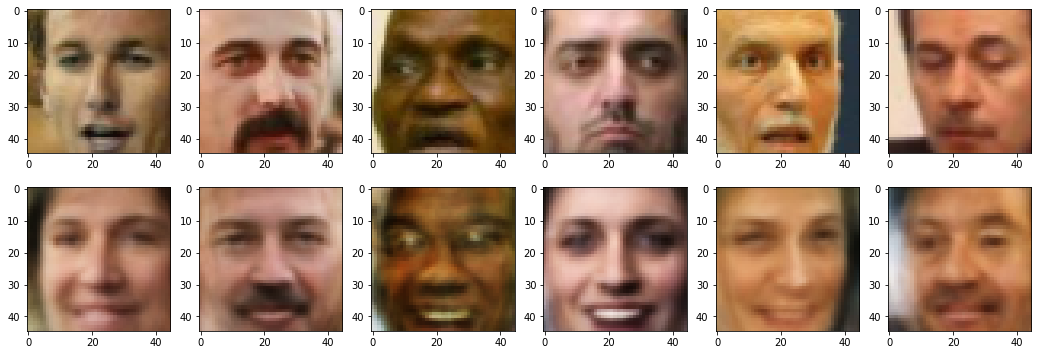

In [68]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(sad_ppl[i].cpu().numpy())
    plt.subplot(2, 6, 7 + i)
    plt.imshow(make_sad_smile(sad_ppl[i]).cpu().detach().view(45, 45, 3).numpy())

plt.show();

Вуаля! Вы восхитительны!

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [18]:
# загрузка датасета 
from torchvision import datasets, transforms
import torchvision.datasets as datasets
bs = 512
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Архитектуа модели 

In [19]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.z_dim = z_dim

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=100)
if torch.cuda.is_available():
    vae.cuda()

In [20]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=100, bias=True)
  (fc32): Linear(in_features=256, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [21]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses

def loss_function(recon_x, x, mu, log_var):
    BCE =  F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD) 

И обучим модель:

In [22]:
# обучение модели

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [23]:
# def test():
#     vae.eval()
#     test_loss= 0
#     with torch.no_grad():
#         for data, _ in test_loader:
#             data = data.cuda()
#             recon, mu, log_var = vae(data)
            
#             # sum up batch loss
#             test_loss += loss_function(recon, data, mu, log_var).item()
        
#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [24]:
for epoch in range(1, 50):
    train(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.594604
Train Epoch: 1 [51200/60000 (85%)]	Loss: 195.726440
====> Epoch: 1 Average loss: 220.9158
Train Epoch: 2 [0/60000 (0%)]	Loss: 194.809296
Train Epoch: 2 [51200/60000 (85%)]	Loss: 170.329239
====> Epoch: 2 Average loss: 182.8117
Train Epoch: 3 [0/60000 (0%)]	Loss: 167.500580
Train Epoch: 3 [51200/60000 (85%)]	Loss: 148.852951
====> Epoch: 3 Average loss: 157.9752
Train Epoch: 4 [0/60000 (0%)]	Loss: 151.020523
Train Epoch: 4 [51200/60000 (85%)]	Loss: 140.012756
====> Epoch: 4 Average loss: 142.9888
Train Epoch: 5 [0/60000 (0%)]	Loss: 136.045166
Train Epoch: 5 [51200/60000 (85%)]	Loss: 130.629105
====> Epoch: 5 Average loss: 133.2972
Train Epoch: 6 [0/60000 (0%)]	Loss: 127.697327
Train Epoch: 6 [51200/60000 (85%)]	Loss: 123.677078
====> Epoch: 6 Average loss: 126.2375
Train Epoch: 7 [0/60000 (0%)]	Loss: 124.928955
Train Epoch: 7 [51200/60000 (85%)]	Loss: 121.462585
====> Epoch: 7 Average loss: 121.2367
Train Epoch: 8 [0/60000 (0%)]	Loss: 118.4

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


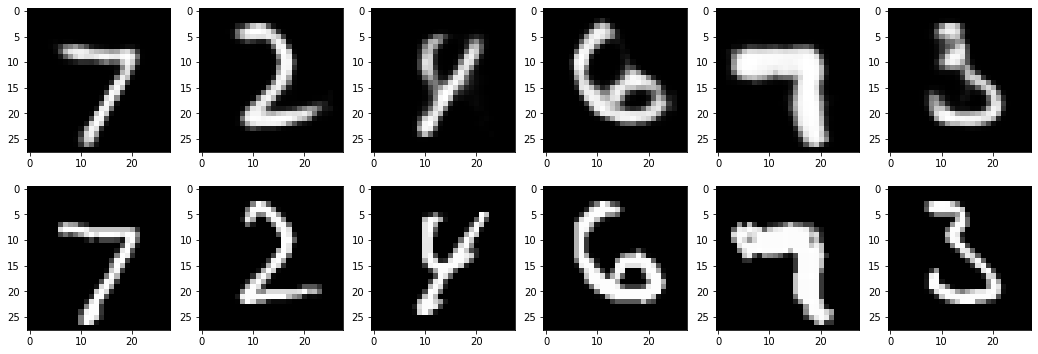

In [25]:
plt.figure(figsize=(18, 6))
for i, (test_data, _) in enumerate(test_loader):
    if i >= 6:
      break
    plt.subplot(2, 6, i + 1)
    recon_batch, mu, log_var = vae(test_data.cuda())
    
    plt.imshow(recon_batch[0].cpu().view(28, 28).detach().numpy(), cmap='gray')
    plt.subplot(2, 6, i + 7)
    
    test_data_for_print = test_data.cpu()[0]
    test_data_for_print = torch.squeeze(test_data_for_print)
    plt.imshow(test_data_for_print, cmap='gray')

plt.show();

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


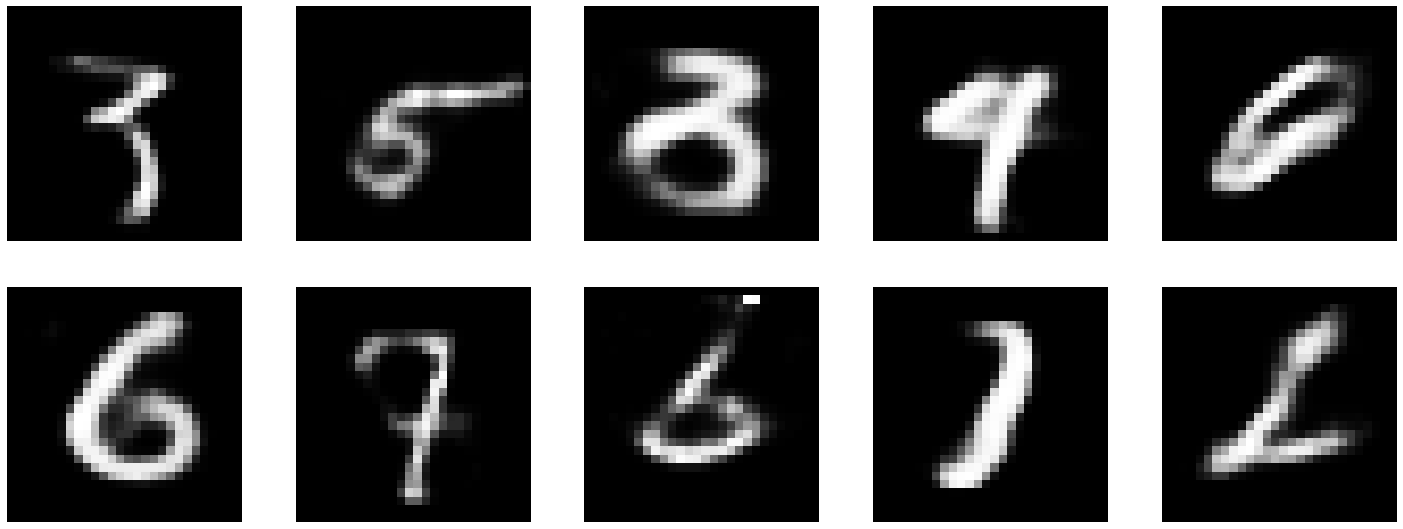

In [26]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных

z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
z = torch.from_numpy(z).type(torch.FloatTensor)
z = z.cuda()

x =  vae.decoder(z)

output = x

plt.figure(figsize=(25, 25))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(output[i].cpu().detach().view(28, 28).numpy(), cmap='gray')


plt.show();

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [27]:
vae_faces = VAE(x_dim=45*45*3, h_dim1=1024, h_dim2=512, z_dim=256)

def loss_function(recon_x, x, mu, log_var):
    BCE =  45 * 45 * F.binary_cross_entropy(recon_x, x.view(-1, 45*45*3), reduction='sum') 
    KLD = -0.5 *  torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD) / 2 / 45 / 45 / 100

optimizer = torch.optim.Adam(vae_faces.parameters(), lr=1e-4)

In [28]:
losses = []

EPOCHS = 150
vae_faces.cuda()
vae_faces.train()
train_loss = 0

for epoch in range(EPOCHS):
    
  for batch_idx, (img, _) in enumerate(train_dataloader):
    img = img.cuda()
    img = torch.flatten(img, start_dim=1, end_dim=3)
    optimizer.zero_grad()

    recon_batch, mu, log_var = vae_faces(img)
    loss = loss_function(recon_batch, img, mu, log_var)
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(img), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item() / len(img)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))
    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/9857 (0%)]	Loss: 21.088911
====> Epoch: 0 Average loss: 20.0861
Train Epoch: 1 [0/9857 (0%)]	Loss: 19.805631
====> Epoch: 1 Average loss: 39.6148
Train Epoch: 2 [0/9857 (0%)]	Loss: 19.441960
====> Epoch: 2 Average loss: 58.8501
Train Epoch: 3 [0/9857 (0%)]	Loss: 19.155731
====> Epoch: 3 Average loss: 77.9405
Train Epoch: 4 [0/9857 (0%)]	Loss: 19.084762
====> Epoch: 4 Average loss: 96.9644
Train Epoch: 5 [0/9857 (0%)]	Loss: 19.014153
====> Epoch: 5 Average loss: 115.9461
Train Epoch: 6 [0/9857 (0%)]	Loss: 18.962795
====> Epoch: 6 Average loss: 134.8865
Train Epoch: 7 [0/9857 (0%)]	Loss: 18.918627
====> Epoch: 7 Average loss: 153.8086
Train Epoch: 8 [0/9857 (0%)]	Loss: 18.904727
====> Epoch: 8 Average loss: 172.7171
Train Epoch: 9 [0/9857 (0%)]	Loss: 18.898119
====> Epoch: 9 Average loss: 191.6224
Train Epoch: 10 [0/9857 (0%)]	Loss: 18.892729
====> Epoch: 10 Average loss: 210.5105
Train Epoch: 11 [0/9857 (0%)]	Loss: 18.867830
====> Epoch: 11 Average loss: 229.3657
Train

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


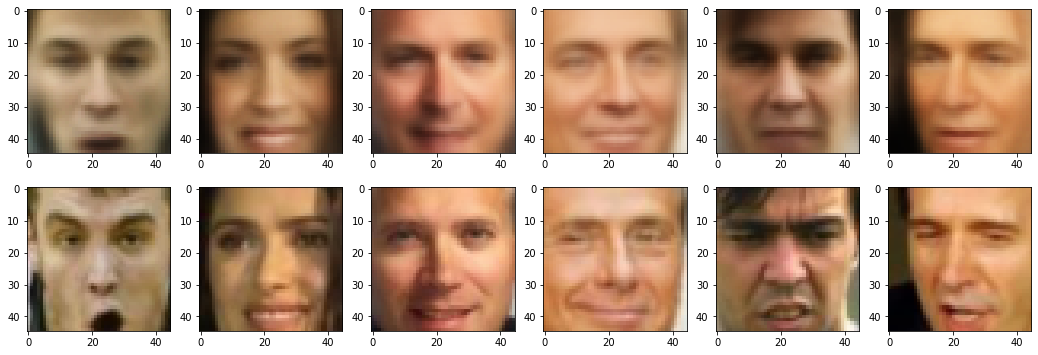

In [29]:
plt.figure(figsize=(18, 6))
for i, (val_data, _) in enumerate(val_dataloader):
    if i >= 6:
      break
    plt.subplot(2, 6, i + 1)
    img = torch.flatten(val_data, start_dim=1, end_dim=3)
    recon_batch, mu, log_var = vae_faces(img.cuda())

    plt.imshow(recon_batch.cpu().detach().view(100, 45, 45, 3).numpy()[0])
    plt.subplot(2, 6, 7 + i)
    plt.imshow(val_data.cpu()[0])

plt.show();

In [30]:
recon_batch, mu, log_var = vae_faces(val_X_torch.cuda())
mu_np = mu.cpu().exp().sqrt().detach().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [31]:
%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(mu_np)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


In [32]:
val_Y_df = pd.DataFrame(data=val_Y,
                columns=attrs.columns)
val_Y_df['Male'][:10]


0    0.733790
1    0.086973
2   -0.895717
3    2.273677
4    1.625728
5   -1.196606
6    1.030151
7    0.217841
8    1.661093
9   -0.754057
Name: Male, dtype: float64

In [33]:
colors = [0 if val_Y_df['Male'][i] < 0 else 1 for i in range(val_Y_df.shape[0])]
colors[:10]

[1, 1, 0, 1, 1, 0, 1, 1, 1, 0]

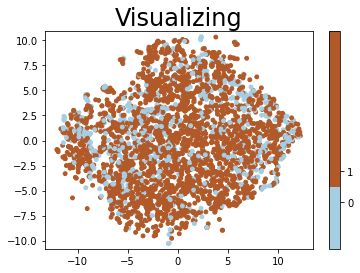

In [34]:
plt.scatter(tsne[:, 0], tsne[:, 1] ,s= 15, c=colors, cmap='Paired')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-1.5).set_ticks(np.arange(2))
plt.title('Visualizing', fontsize=24);

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [35]:
<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

SyntaxError: ignored

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>


Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

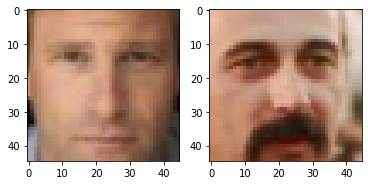

In [36]:
first_pic = data[0]
first_pic_tenzor = torch.from_numpy(first_pic).type(torch.FloatTensor)
plt.subplot(1, 2, 1)
plt.imshow(first_pic_tenzor.cpu().numpy())

second_pic = data[10]
second_pic_tenzor = torch.from_numpy(second_pic).type(torch.FloatTensor)
plt.subplot(1, 2, 2)
plt.imshow(second_pic_tenzor.cpu().numpy())

In [37]:
import math 

def image_morphing(from_pic, to_pic):
  from_pic = torch.reshape(from_pic, (1, 45, 45, 3))
  to_pic = torch.reshape(to_pic, (1, 45, 45, 3))
  latent_from = autoencoder.encode(from_pic)
  latent_to = autoencoder.encode(to_pic)
  plt.figure(figsize=(18, 10))
  for i in range(0, 11):
    plt.subplot(2, 11, i + 1)
    alpha = i / 10
    morph = torch.add(torch.mul(latent_from, 1 - alpha), torch.mul(latent_to, alpha))
    plt.imshow(autoencoder.decode(morph).cpu().view(45, 45, 3).detach().numpy())
  plt.show();

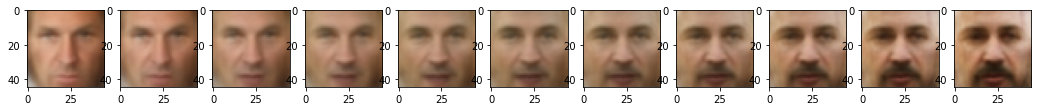

In [38]:
image_morphing(first_pic_tenzor.cuda(), second_pic_tenzor.cuda())

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


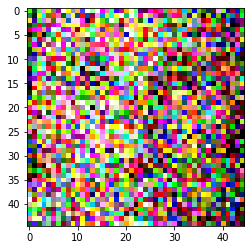

In [39]:
noise_factor = 0.5
X = data[0]
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
plt.imshow(X_noisy) 

In [40]:
# loss
criterion = nn.MSELoss() # nn.MSELoss()

denoising_ae = Autoencoder()
# Ваш любимый оптимизатор

import torch.optim as optim
optimizer = torch.optim.Adam(denoising_ae.parameters(), lr=1e-4)

In [41]:
losses = []

EPOCHS = 100

denoising_ae.cuda()
denoising_ae.train()

for epoch in range(EPOCHS):
  train_loss = 0
  for batch_idx, (img, _) in enumerate(train_dataloader):

    img = img.cuda()

    noise_arr = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    noise_tenzor = torch.from_numpy(noise_arr).type(torch.FloatTensor)
    noise_tenzor = noise_tenzor.cuda()
    noise_img = torch.add(img, noise_tenzor)

    optimizer.zero_grad()
    #print(data.shape)
    reconstruction, code = denoising_ae(noise_img)
    loss = criterion(reconstruction, img.view(-1, 6075))
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(img), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))
    

Train Epoch: 0 [0/9857 (0%)]	Loss: 0.044832
====> Epoch: 0 Average loss: 0.0003
Train Epoch: 1 [0/9857 (0%)]	Loss: 0.025999
====> Epoch: 1 Average loss: 0.0002
Train Epoch: 2 [0/9857 (0%)]	Loss: 0.018674
====> Epoch: 2 Average loss: 0.0002
Train Epoch: 3 [0/9857 (0%)]	Loss: 0.015788
====> Epoch: 3 Average loss: 0.0002
Train Epoch: 4 [0/9857 (0%)]	Loss: 0.013953
====> Epoch: 4 Average loss: 0.0001
Train Epoch: 5 [0/9857 (0%)]	Loss: 0.012943
====> Epoch: 5 Average loss: 0.0001
Train Epoch: 6 [0/9857 (0%)]	Loss: 0.012599
====> Epoch: 6 Average loss: 0.0001
Train Epoch: 7 [0/9857 (0%)]	Loss: 0.012747
====> Epoch: 7 Average loss: 0.0001
Train Epoch: 8 [0/9857 (0%)]	Loss: 0.011481
====> Epoch: 8 Average loss: 0.0001
Train Epoch: 9 [0/9857 (0%)]	Loss: 0.011067
====> Epoch: 9 Average loss: 0.0001
Train Epoch: 10 [0/9857 (0%)]	Loss: 0.010679
====> Epoch: 10 Average loss: 0.0001
Train Epoch: 11 [0/9857 (0%)]	Loss: 0.010449
====> Epoch: 11 Average loss: 0.0001
Train Epoch: 12 [0/9857 (0%)]	Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


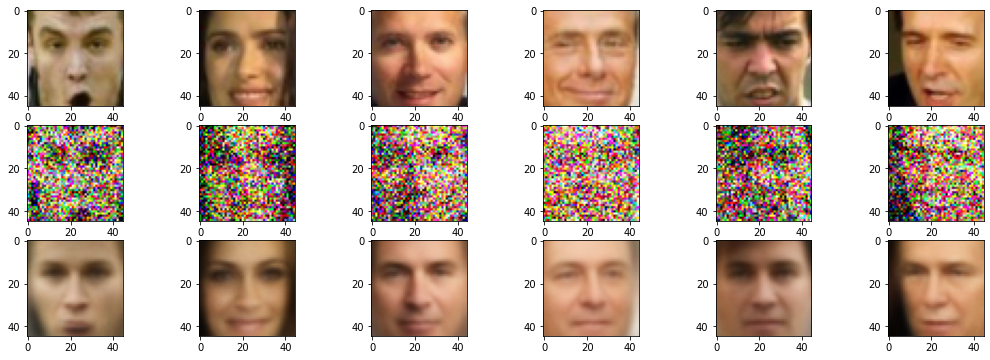

In [42]:
plt.figure(figsize=(18, 6))
for i, (val_data, _) in enumerate(val_dataloader):
    if i >= 6:
      break
    noise_arr = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_data.shape)
    noise_tenzor = torch.from_numpy(noise_arr).type(torch.FloatTensor)
    noise_tenzor = noise_tenzor
    noise_val_data = torch.add(val_data, noise_tenzor)
    
    plt.subplot(3, 6, 1 + i)
    plt.imshow(val_data.cpu()[0])
    plt.subplot(3, 6, 7 + i)
    plt.imshow(noise_val_data.cpu()[0])
    plt.subplot(3, 6, 13 + i)
    result, kek = denoising_ae(noise_val_data.cuda())
    plt.imshow(result.cpu().detach().view(100, 45, 45, 3).numpy()[0])


plt.show();

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

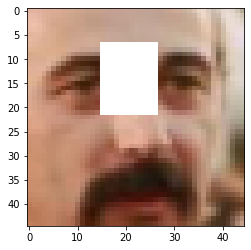

In [43]:
def hide_part(img):
  [wx, wy], [hx, hy] = np.random.randint(45, size=(2, 2))
  if (wx > wy):
    wx, wy = wy, wx
  
  if (hx > hy):
    hx, hy = hy, hx
  
  wy += 10
  hy += 10

  while wy - wx > 15:
    wy -= 5
  
  while hy - hx > 15:
    hy -= 5

  img[wx:wy, hx:hy, 0] = 1
  img[wx:wy, hx:hy, 1] = 1
  img[wx:wy, hx:hy, 2] = 1

  return img


plt.imshow(hide_part(np.array(data[10], copy=True)))

In [44]:
def hide_part_tensor(img):
  img = img.numpy()
  for pic in img:
    pic = hide_part(pic)
  img = torch.from_numpy(img).type(torch.FloatTensor)
  return img

In [45]:
# loss
criterion = nn.MSELoss() # nn.MSELoss()

occlusion_ae = Autoencoder()
# Ваш любимый оптимизатор

import torch.optim as optim
optimizer = torch.optim.Adam(occlusion_ae.parameters(), lr=1e-4)

In [46]:
losses = []

EPOCHS = 100

occlusion_ae.cuda()
occlusion_ae.train()

for epoch in range(EPOCHS):
  train_loss = 0
  for batch_idx, (img, _) in enumerate(train_dataloader):

    img = img.cuda()

    occluded_img = img.detach().clone().cpu()
    occluded_img = hide_part_tensor(occluded_img)

    optimizer.zero_grad()
    reconstruction, code = occlusion_ae(occluded_img.cuda())
    loss = criterion(reconstruction, img.view(-1, 6075))
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(img), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))
    

Train Epoch: 0 [0/9857 (0%)]	Loss: 0.044858
====> Epoch: 0 Average loss: 0.0003
Train Epoch: 1 [0/9857 (0%)]	Loss: 0.026918
====> Epoch: 1 Average loss: 0.0002
Train Epoch: 2 [0/9857 (0%)]	Loss: 0.020425
====> Epoch: 2 Average loss: 0.0002
Train Epoch: 3 [0/9857 (0%)]	Loss: 0.017403
====> Epoch: 3 Average loss: 0.0002
Train Epoch: 4 [0/9857 (0%)]	Loss: 0.015648
====> Epoch: 4 Average loss: 0.0001
Train Epoch: 5 [0/9857 (0%)]	Loss: 0.013615
====> Epoch: 5 Average loss: 0.0001
Train Epoch: 6 [0/9857 (0%)]	Loss: 0.012692
====> Epoch: 6 Average loss: 0.0001
Train Epoch: 7 [0/9857 (0%)]	Loss: 0.012335
====> Epoch: 7 Average loss: 0.0001
Train Epoch: 8 [0/9857 (0%)]	Loss: 0.012266
====> Epoch: 8 Average loss: 0.0001
Train Epoch: 9 [0/9857 (0%)]	Loss: 0.011805
====> Epoch: 9 Average loss: 0.0001
Train Epoch: 10 [0/9857 (0%)]	Loss: 0.011010
====> Epoch: 10 Average loss: 0.0001
Train Epoch: 11 [0/9857 (0%)]	Loss: 0.010956
====> Epoch: 11 Average loss: 0.0001
Train Epoch: 12 [0/9857 (0%)]	Loss: 

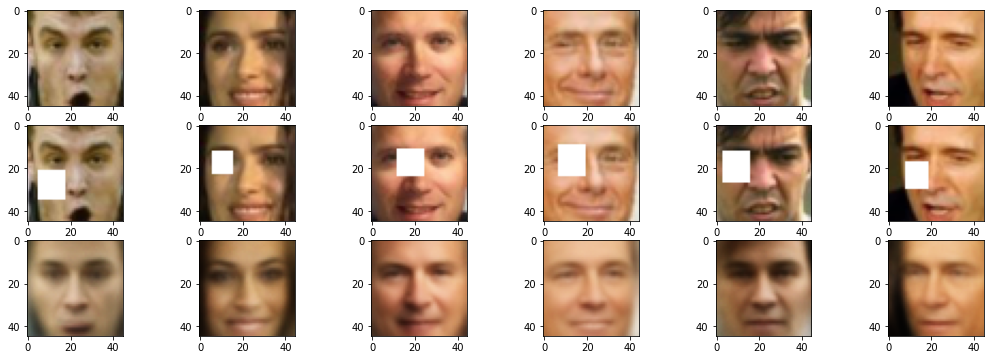

In [47]:
plt.figure(figsize=(18, 6))
for i, (val_data, _) in enumerate(val_dataloader):
    if i >= 6:
      break
    occluded_img = val_data.data.detach().clone()
    occluded_img = hide_part_tensor(occluded_img)
    
    plt.subplot(3, 6, 1 + i)
    plt.imshow(val_data.cpu()[0])
    
    plt.subplot(3, 6, 7 + i)
    plt.imshow(occluded_img.cpu()[0])
    
    plt.subplot(3, 6, 13 + i)
    result, kek = occlusion_ae(occluded_img.cuda())
    plt.imshow(result.cpu().detach().view(100, 45, 45, 3).numpy()[0])


plt.show();

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [48]:
img = torch.flatten(train_X_torch, start_dim=1, end_dim=3)
img.shape

torch.Size([9857, 6075])

In [49]:
latent = autoencoder.encode(train_X_torch.cuda())

In [50]:
from sklearn.neighbors import NearestNeighbors

In [51]:
# обучаем LSHFores
# from sklearn.neighbors import LSHForest
lshf = NearestNeighbors(n_neighbors=50).fit(latent.cpu().detach().numpy())

In [52]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

  image_code =  torch.from_numpy(image).type(torch.FloatTensor).unsqueeze(0)
  #image_code = image_code.view(-1, 45*45*3 )

  code = autoencoder.encode(image_code.cuda())
    
  (distances,),(idx,) = lshf.kneighbors(code.cpu().detach().numpy(), n_neighbors=n_neighbors)

  return distances, train_X[idx]

In [53]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

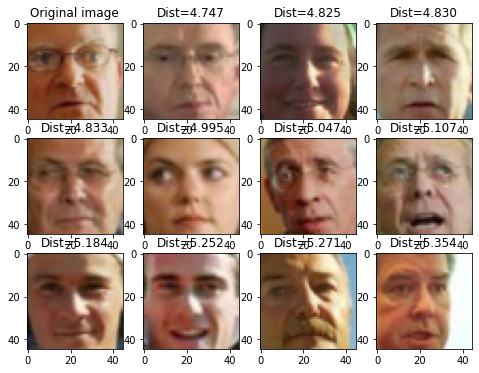

In [55]:
show_similar(val_X[14])

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!